In [1]:
import os
import torch
import kagglehub
import shutil
import os
from huggingface_hub import notebook_login
import wandb
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image,ImageFile
import os
import csv
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering
import os
import accelerate
import sys
import subprocess
import os
import shutil
import pandas as pd

print(f"PyTorch Version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: No GPU detected. Check your CUDA / GPU drivers.")

print("Dependencies installed successfully.")


PyTorch Version: 2.5.1+cu121
GPU: NVIDIA GeForce RTX 3060 Ti
Dependencies installed successfully.


In [2]:
# @title 2. Login to Services

print("--- Hugging Face Login ---")
print("You need a read-access token from https://huggingface.co/settings/tokens")
notebook_login()

print("\n--- Weights & Biases Login ---")
print("You need an API key from https://wandb.ai/authorize")
wandb.login()

--- Hugging Face Login ---
You need a read-access token from https://huggingface.co/settings/tokens



--- Weights & Biases Login ---
You need an API key from https://wandb.ai/authorize


wandb: Currently logged in as: benoit-b (benoit-b-utbm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating baseline image...


  0%|          | 0/50 [00:00<?, ?it/s]

Baseline Result (Expected Failure):


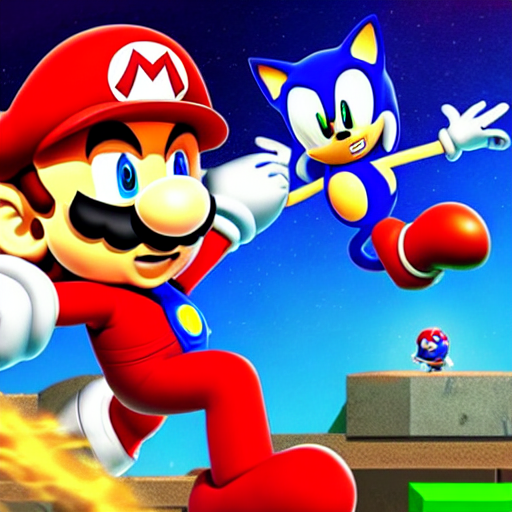

In [13]:
# @title Run Baseline Inference

# 1. Load SD1.5
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# 2. Prompt for a mask
prompt = "Generate me a cover for a platform video game where mario et sonic play on a fire planet"

# 3. Generate
print("Generating baseline image...")
image = pipe(prompt).images[0]
image.save("baseline_failure.png")

# 4. Display
print("Baseline Result (Expected Failure):")
display(image)

# 5. Clean up memory for training
del pipe
torch.cuda.empty_cache()

In [ ]:
# Download
path = kagglehub.dataset_download("veerpandya/video-game-covers")
print("Downloaded to:", path)

target_path = r"D:\Desktop\Devoirs UTBM\BR\BR04\AI54\dataset"
os.makedirs(target_path, exist_ok=True)

shutil.copytree(path, target_path, dirs_exist_ok=True)

print("Moved dataset to:", target_path)

In [5]:
def open_image_safe(path):
    ImageFile.LOAD_TRUNCATED_IMAGES = True
    try:
        img = Image.open(path).convert("RGB")
        return img
    except Exception as e:
        print(f"Failed to open {path}: {e}")
        return None


In [ ]:
from tqdm import tqdm
import os
dataset_dir = "dataset"
output_csv = "captions.csv"

# Load BLIP
model_id = "Salesforce/blip-vqa-base"
processor = BlipProcessor.from_pretrained(model_id)
model = BlipForQuestionAnswering.from_pretrained(model_id)

def generate_caption(image_path):
    img = open_image_safe(image_path)
    if img is None:
        return None

    question = (
        "Describe this video game cover in rich visual detail. "
        "Mention characters, creatures, actions, environment, objects, colors, mood, and visible text."
    )

    inputs = processor(img, question, return_tensors="pt")
    out = model.generate(**inputs, max_new_tokens=128)

    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption.strip()

rows = []

# Collect all image paths
all_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # optional filter
            all_files.append(os.path.join(root, file))


for img_path in tqdm(all_files, desc="Processing images"):        
        if img_path.lower().endswith((".png", ".jpg", ".jpeg")):
            parts = img_path.split("\\")
            game_type = parts[2]
            game_name = os.path.splitext(parts[-1])[0].replace("-", " ")

            visual_desc = generate_caption(img_path)

            final_caption = (
                f"This is a cover of a {game_type} video game named {game_name}. "
                f"We can see on the cover: {visual_desc}"
            )

            #print("Processed:", img_path)
            rows.append([img_path, final_caption])

# Save CSV
with open(output_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["img_path", "caption"])
    writer.writerows(rows)

print("Done! Saved to", output_csv)


Processing images:   0%|          | 19/5000 [00:11<48:00,  1.73it/s] d:\Desktop\Devoirs UTBM\BR\BR04\AI54\.venv\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Processing images: 100%|██████████| 5000/5000 [50:30<00:00,  1.65it/s] 

Done! Saved to captions.csv


In [ ]:
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/v0.35.2/examples/text_to_image/train_text_to_image_lora.py

In [ ]:
os.environ["MODEL_NAME"] = "runwayml/stable-diffusion-v1-5"
os.environ["TRAIN_DIR"] = "training_512"
os.environ["OUTPUT_DIR"] = "sd-indoor-segmentation-lora"

In [12]:
# Paths
original_dataset = "dataset/dataset"
output_dir = "training_512_filtered"
captions_file = os.path.join(original_dataset, "captions.csv")
output_captions_file = os.path.join(output_dir, "metadata.csv")

def strip_png_metadata(path):
    try:
        with Image.open(path) as img:
            # Convert image mode to RGB or RGBA
            img = img.convert("RGBA") if img.mode in ["RGBA", "LA"] else img.convert("RGB")
            
            # Overwrite the original file without metadata
            img.save(path, optimize=True)
    except Exception as e:
        print(f"Failed to clean {path}: {e}")
        # fallback: try using ImageFile.LOAD_TRUNCATED_IMAGES
        from PIL import ImageFile
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        try:
            with Image.open(path) as img:
                img = img.convert("RGBA") if img.mode in ["RGBA", "LA"] else img.convert("RGB")
                img.save(path, optimize=True)
                print(f"Cleaned with fallback: {path}")
        except Exception as e2:
            print(f"Failed again: {path}, {e2}")

def resize(input_path,output_path):
    target_size = (512, 512)

    # Open and resize image
    with Image.open(input_path) as img:
        resized_img = img.resize(target_size, Image.LANCZOS)
        resized_img.save(output_path)

# Create output folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load captions
captions_df = pd.read_csv(captions_file, names=['img_path', 'caption'])
#print(captions_df)
# Prepare a list to store new captions
new_captions = []

# Loop through all subfolders
for root, _, files in os.walk(original_dataset):
    if root == r"dataset/dataset\fighting" or root == r"dataset/dataset\platform":
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                old_path = os.path.join(root, filename)
                
                # Copy file to output_dir
                new_filename = filename
                counter = 1
                while os.path.exists(os.path.join(output_dir, new_filename)):
                    name, ext = os.path.splitext(filename)
                    new_filename = f"{name}_{counter}{ext}"
                    counter += 1
                strip_png_metadata(old_path)
                resize(old_path,os.path.join(output_dir, new_filename))
                
                # Update captions
                old_path = old_path.replace("\\", "/").replace("/","\\")
                row = captions_df[captions_df['img_path'] == old_path]
                if not row.empty:
                    row = row.copy()
                    row['img_path'] = new_filename
                    new_captions.append(row)

# Combine all updated captions and save
if new_captions:
    new_captions_df = pd.concat(new_captions, ignore_index=True)
    new_captions_df = new_captions_df.rename(columns={
        'img_path': 'file_name',
        'caption': 'label'
    })
    filtered_df = new_captions_df[new_captions_df["label"].str.contains("platform|fighting", case=True, na=False)]
    filtered_df.to_csv(output_captions_file, index=False, header=True)
    print(f"Training data created in '{output_dir}' with updated captions.")
else:
    print("No captions matched. Check your captions.csv paths.")
            

Training data created in 'training_512_filtered' with updated captions.


In [ ]:
accelerate launch train_text_to_image_lora.py --pretrained_model_name_or_path runwayml/stable-diffusion-v1-5 --train_data_dir training_512_filtered/ --caption_column label --resolution 512 --train_batch_size 2 --gradient_accumulation_steps 4 --max_train_steps 4000 --learning_rate 5e-5 --max_grad_norm 1.0 --lr_scheduler cosine --lr_warmup_steps 200 --output_dir sd-fighting-platform-cover-lora --mixed_precision fp16 --seed 42  --report_to tensorboard --validation_prompt "A dynamic fighting and platformer video game cover, bold characters, dramatic lighting, high contrast, professional game art" --checkpointing_steps 500 --checkpoints_total_limit 3 --rank 64


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Generating LoRA result...


  0%|          | 0/30 [00:00<?, ?it/s]

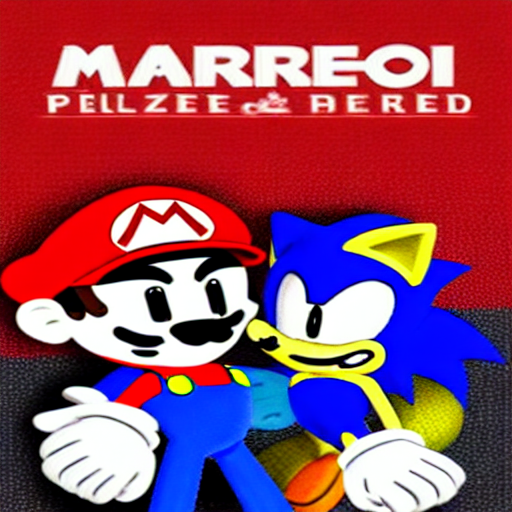

In [15]:
# @title Run LoRA Inference
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image

# 1. Load Base Model
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# 2. Load the LoRA weights
lora_path = r"D:\Desktop\Devoirs UTBM\BR\BR04\AI54\sd-fighting-platform-cover-lora\pytorch_lora_weights.safetensors"
pipe.load_lora_weights(lora_path)

# 3. Prompt matches the style used in training
prompt = "Generate me a cover for a platform video game where mario et sonic play on a fire planet"

# 4. Generate
print("Generating LoRA result...")
image = pipe(prompt, num_inference_steps=30).images[0]

# 5. Display and Save
image.save("lora_final_result.png")
display(image)